# Deep Learning Project
## Semantic image segmentation with Deloitte Consulting

### Initializations and loading in data

In [28]:
import os
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import pickle
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from CustomDataset import *
import fnmatch
import random


#matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import seaborn as sns
import torch
from sklearn import metrics # For the confussion matrix
from sklearn.metrics import f1_score
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import transforms
from CustomDataset import *
import random
import os
from sklearn.model_selection import train_test_split
import fnmatch
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

Load in the data

In [20]:
# Finding the paths for the test images and the rest
data_folder = "c:/Users/Laura/Dropbox/Skole/DTU/9.semester/Deep Learning/Exercises/Project/carseg_data (3)/carseg_data/arrays/"
paths = [os.path.join(data_folder, name) for name in os.listdir(data_folder)]

path_test = "c:/Users/Laura/Dropbox/Skole/DTU/9.semester/Deep Learning/Exercises/Project/carseg_data (3)/carseg_data/arrays/"
get_test_paths = [path_test + 'photo_0006.npy', 
 path_test + 'photo_0039.npy', 
 path_test + 'photo_0160.npy', 
 path_test + 'photo_0057.npy', 
 path_test + 'photo_0117.npy', 
 path_test + 'photo_0090.npy', 
 path_test + 'photo_0004.npy', 
 path_test + 'photo_0047.npy', 
 path_test + 'photo_0165.npy', 
 path_test + 'photo_0046.npy', 
 path_test + 'photo_0080.npy', 
 path_test + 'photo_0069.npy', 
 path_test + 'photo_0148.npy', 
 path_test + 'photo_0018.npy', 
 path_test + 'photo_0038.npy', 
 path_test + 'photo_0002.npy', 
 path_test + 'photo_0085.npy', 
 path_test + 'photo_0026.npy', 
 path_test + 'photo_0113.npy', 
 path_test + 'photo_0070.npy', 
 path_test + 'photo_0009.npy', 
 path_test + 'photo_0029.npy', 
 path_test + 'photo_0108.npy', 
 path_test + 'photo_0061.npy', 
 path_test + 'photo_0088.npy']

# Removing test images from the training data
for i in range(len(get_test_paths)):
    if get_test_paths[i] in paths:
        paths.remove(get_test_paths[i])
        
        
data = [np.load(file_path) for file_path in paths]
test_data = [np.load(file_path) for file_path in get_test_paths]


# Split data into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)


# Transform to greyscale if UNet model is used
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1)
    ]
)  
    
#################### Dataloader ############################

# Batch size for train and val
batch_size = 3

# Batch size for test
batch_size_test = 1


# Dataset and Dataloader for Unet
train_dataset_unet = CustomDataset(train_data, transform=transform, target_transform = None)
validation_dataset_unet = CustomDataset(validation_data, transform=transform, target_transform = None)
test_dataset_unet = CustomDataset(test_data, transform=transform, target_transform = None)

train_dataloader_unet = DataLoader(train_dataset_unet, batch_size=batch_size, shuffle=True, drop_last=False)
validation_dataloader_unet = DataLoader(validation_dataset_unet, batch_size=batch_size, shuffle=False,drop_last=True)
test_dataloader_unet = DataLoader(test_dataset_unet, batch_size=batch_size_test, shuffle=False)


# Dataset and Dataloader for Deeplab
train_dataset_deep = CustomDataset(train_data, transform=None, target_transform = None)
validation_dataset_deep = CustomDataset(validation_data, transform=None, target_transform = None)
test_dataset_deep = CustomDataset(test_data, transform=None, target_transform = None)

train_dataloader_deep = DataLoader(train_dataset_deep, batch_size=batch_size, shuffle=True, drop_last=False)
validation_dataloader_deep = DataLoader(validation_dataset_deep, batch_size=batch_size, shuffle=False,drop_last=True)
test_dataloader_deep = DataLoader(test_dataset_deep, batch_size=batch_size_test, shuffle=False)



In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using cpu


Load in the trained models

In [22]:
filepath_deeplab = r"C:\Users\Laura\Dropbox\Skole\DTU\9.semester\Deep Learning\Exercises\Project\Finished code\DL_Project\trained_models\DeepLab_100E.pt"
filepath_unet = r"C:\Users\Laura\Dropbox\Skole\DTU\9.semester\Deep Learning\Exercises\Project\Finished code\DL_Project\trained_models\Unet_100E.pt"


from models.DeepLab_2 import deeplab
from models.UNET import UNet

net_deep = torch.load(filepath_deeplab, map_location=torch.device('cpu'))
net_deep.to(device)

net_unet = torch.load(filepath_unet, map_location=torch.device('cpu'))
net_unet.to(device)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Weighted accuracy score

In [23]:
def acc_score(target, output):
    target = target.cpu().numpy()
    preds = torch.max(output, 1)[1] # find max af hver pixel
    preds = preds.cpu().numpy()
    
    # Calculate accuracy for class 0
    acc_background = f1_score(target.flatten(), preds.flatten(), labels=[0], average='micro')

    # Calculate accuracy for the rest
    acc_classes = f1_score(target.flatten(), preds.flatten(), labels=list(range(1, 9)), average='micro')

    # Weighted accuracy
    weighted_acc = (acc_background / 9) + (acc_classes * 8 / 9)

    return weighted_acc

Function for confussion matrix

In [29]:

def compute_confusion_matrix(target, pred, n_classes, normalize=None):
    cm = metrics.confusion_matrix(
        target.detach().cpu().numpy().flatten(), 
        pred.detach().cpu().numpy().flatten(),
        normalize=normalize,
        labels = list(range(n_classes))
    )
    return cm

### Evaluate test set

Unet model

In [24]:
n_classes = 9
lr = 0.001

# Class weights for CrossEntropyLoss
class_labels = np.concatenate([target.flatten() for image,target in train_dataset_unet])
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(class_labels), y=class_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer function
optimizer = torch.optim.Adam(net_unet.parameters(), lr=lr)

net_unet.eval()
with torch.no_grad():
    cur_acc = 0
    test_accuracies_Unet = []
    for inputs, targets in test_dataloader_unet:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net_unet(inputs)
        
        loss = loss_function(output, targets)
        predictions = torch.max(output,1)[1]
        
        test_accuracies_Unet.append(acc_score(targets, output) * len(inputs))
        
    test_accuracy_Unet = np.sum(test_accuracies_Unet) / 25
    

DeepLabV3+ model

In [25]:
n_classes = 9
confusion_matrix = np.zeros((n_classes, n_classes))
lr = 0.001

# Class weights for CrossEntropyLoss
class_labels = np.concatenate([target.flatten() for image,target in train_dataset_deep])
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(class_labels), y=class_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer function
optimizer = torch.optim.Adam(net_deep.parameters(), lr=lr)

net_deep.eval()
with torch.no_grad():
    cur_acc = 0
    test_accuracies_deep = []
    for inputs, targets in test_dataloader_deep:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net_deep(inputs)
        
        loss = loss_function(output, targets)
        predictions = torch.max(output,1)[1]
        
        test_accuracies_deep.append(acc_score(targets, output) * len(inputs))
        
    test_accuracy_deep = np.sum(test_accuracies_deep) / 25

### Plot of test accuracies for the two models

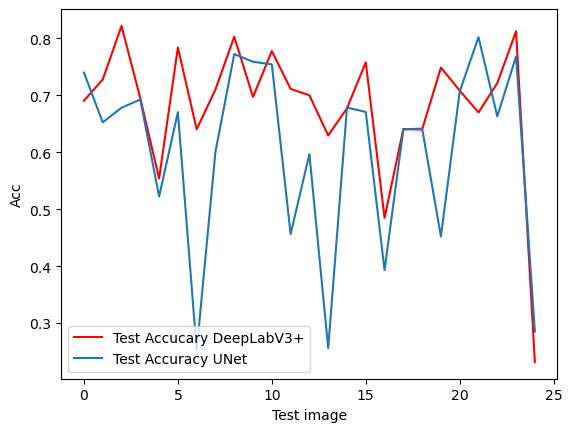

Test accuracy for deeplabv3: 0.681
Test accuracy for unet: 0.604


In [26]:
batches_test = np.arange(25)
plt.figure()
plt.plot(batches_test, test_accuracies_deep, 'r',batches_test, test_accuracies_Unet)
plt.legend(['Test Accucary DeepLabV3+','Test Accuracy UNet'])
plt.xlabel('Test image'), plt.ylabel('Acc')
plt.show()


# Average accuracies:
print(f"Test accuracy for deeplabv3: {test_accuracy_deep:.3f}")
print(f"Test accuracy for unet: {test_accuracy_Unet:.3f}")


### Confussion matrix and class accuracies for DeepLabV3+ model

In [33]:
n_classes = 9
confusion_matrix = np.zeros((n_classes, n_classes))
lr = 0.001

# Class weights for CrossEntropyLoss
class_labels = np.concatenate([target.flatten() for image,target in train_dataset_deep])
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(class_labels), y=class_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer function
optimizer = torch.optim.Adam(net_deep.parameters(), lr=lr)

net_deep.eval()
with torch.no_grad():
    cur_acc = 0
    test_accuracies = []
    for inputs, targets in test_dataloader_deep:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net_deep(inputs)
        
        loss = loss_function(output, targets)
        predictions = torch.max(output,1)[1]
        
        test_accuracies.append(acc_score(targets, output) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions, n_classes, normalize = None)

    test_accuracy = np.sum(test_accuracies) / 25


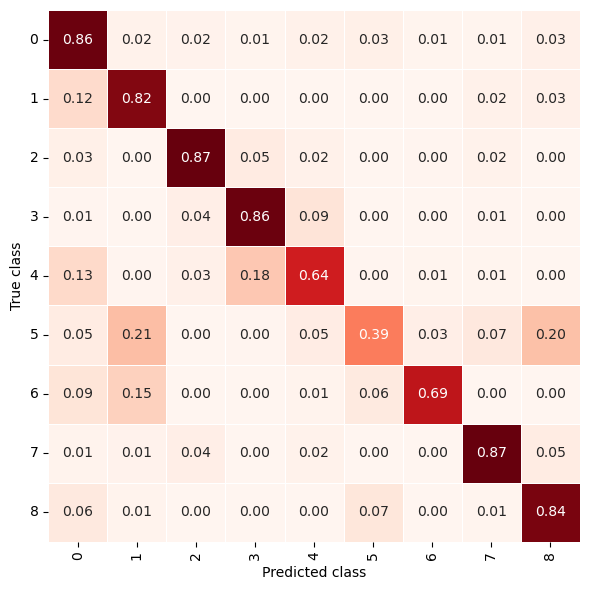

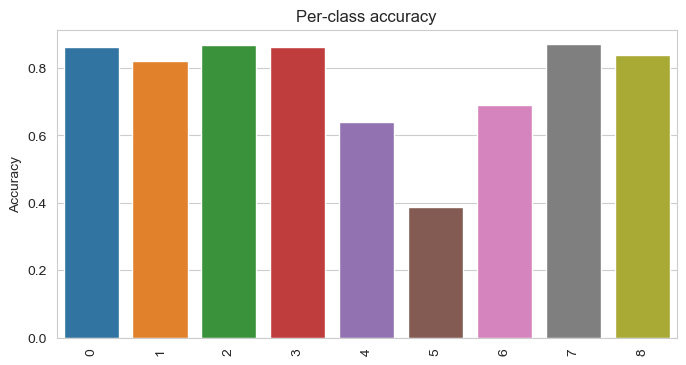

In [32]:
classes = range(0,9)


def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()



with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()
    
    

### Best and worst test predictions DeepLabV3+

In [34]:
acc = []
best_acc_cur = 0
worst_acc_cur = 1

for i in range(len(test_dataset_deep)):
    image,target = test_dataset_deep[i]

    with torch.no_grad():
        lgt = net_deep(image.unsqueeze(0).to(device))
        preds = torch.max(lgt, 1)[1]

    lb = target.cpu()
    acc.append((i,acc_score(lb,lgt)))
    
    if acc_score(lb,lgt) > best_acc_cur:
        best_acc_cur = acc_score(lb,lgt)
        best_index = i
    
    if acc_score(lb,lgt) < worst_acc_cur:
        worst_acc_cur = acc_score(lb,lgt)
        worst_index = i

Best prediction

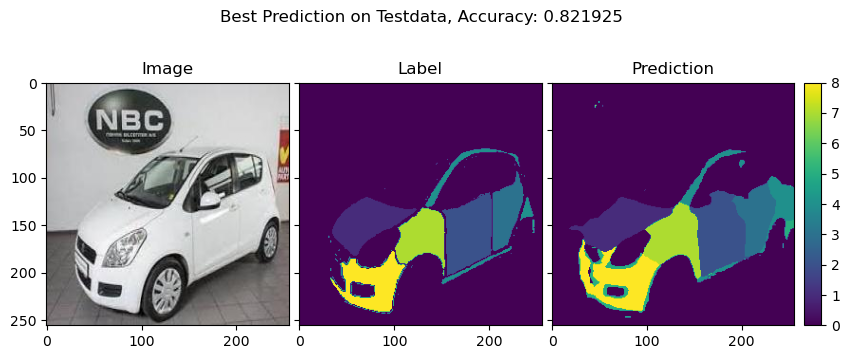

In [35]:
image,target = test_dataset_deep[best_index]

with torch.no_grad():
    lgt = net_deep(image.unsqueeze(0).to(device))
    preds = torch.max(lgt, 1)[1]

im = image.cpu()
im = im.permute(1,2,0)

lb = target.cpu()
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                nrows_ncols=(1,3),
                axes_pad=0.1,
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="7%",
                cbar_pad=0.1,
                )


plots = [im,lb,preds[0,:,:].cpu().detach()]
ii = 0
titles = ["Image", "Label", "Prediction"]
for ax in grid:
    show = ax.imshow(plots[ii])
    ax.set_title(titles[ii])
    ii +=1
    
ax.cax.colorbar(show)

fig.suptitle("Best Prediction on Testdata, Accuracy: %f"%(best_acc_cur))

plt.show()

Worst prediction

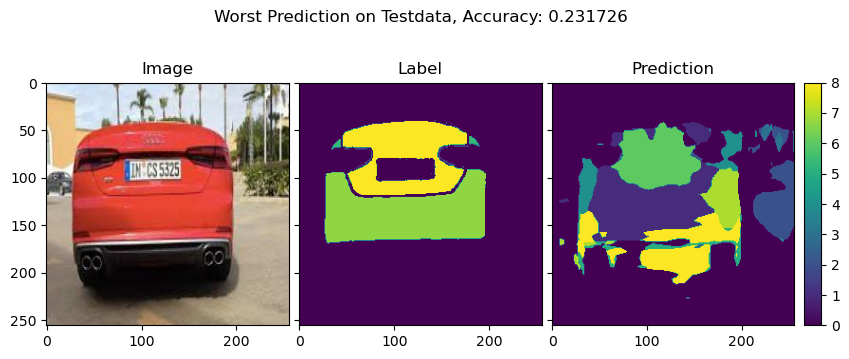

In [36]:
image,target = test_dataset_deep[worst_index]

with torch.no_grad():
    lgt = net_deep(image.unsqueeze(0).to(device))
    preds = torch.max(lgt, 1)[1]

im = image.cpu()
im = im.permute(1,2,0)

lb = target.cpu()
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                nrows_ncols=(1,3),
                axes_pad=0.1,
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="7%",
                cbar_pad=0.1,
                )


plots = [im,lb,preds[0,:,:].cpu().detach()]
ii = 0
titles = ["Image", "Label", "Prediction"]
for ax in grid:
    show = ax.imshow(plots[ii])
    ax.set_title(titles[ii])
    ii +=1
    
ax.cax.colorbar(show)

fig.suptitle("Worst Prediction on Testdata, Accuracy: %f"%(worst_acc_cur))

plt.show()

Get stats for the test accuracies

In [38]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = "Error"

for i in range(len(test_dataset_deep)):
    image,target = test_dataset_deep[i]

    with torch.no_grad():
        lgt = net_deep(image.unsqueeze(0).to(device))
        preds = torch.max(lgt, 1)[1]

    lb = target.cpu()
    
    if acc_score(lb,lgt) < 0.2:
        count1 +=1
    elif acc_score(lb,lgt) >= 0.2 and acc_score(lb,lgt) < 0.4:
        count2 +=1
    elif acc_score(lb,lgt) >= 0.4 and acc_score(lb,lgt) < 0.6:
        count3 +=1
    elif acc_score(lb,lgt) >= 0.6 and acc_score(lb,lgt) < 0.8:
        count4 +=1
    elif acc_score(lb,lgt) >= 0.8 and acc_score(lb,lgt) <= 1:
        count5 +=1
    else:
        print(count6)
   
print(count1)
print(count2)
print(count3)
print(count4)
print(count5)
   

0
1
2
19
3


Print predictions for all test images

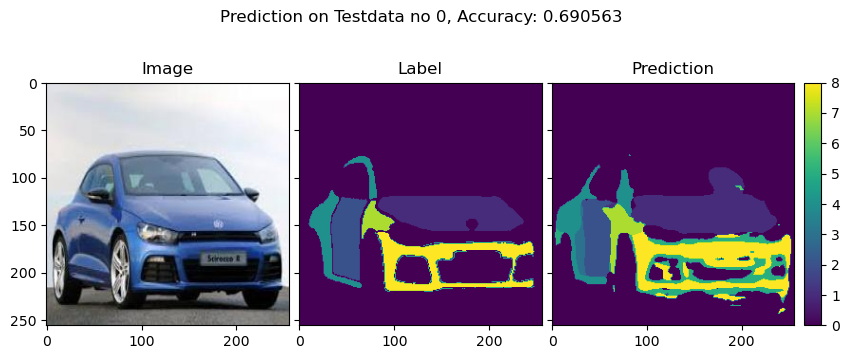

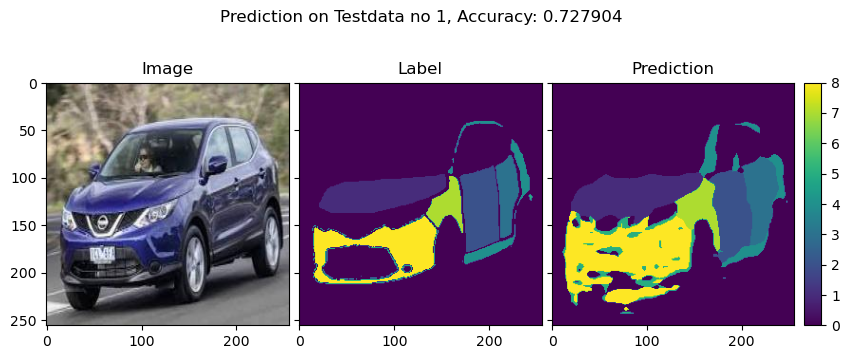

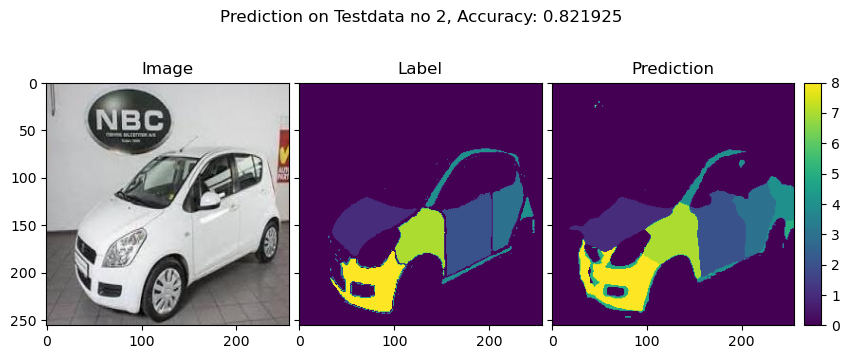

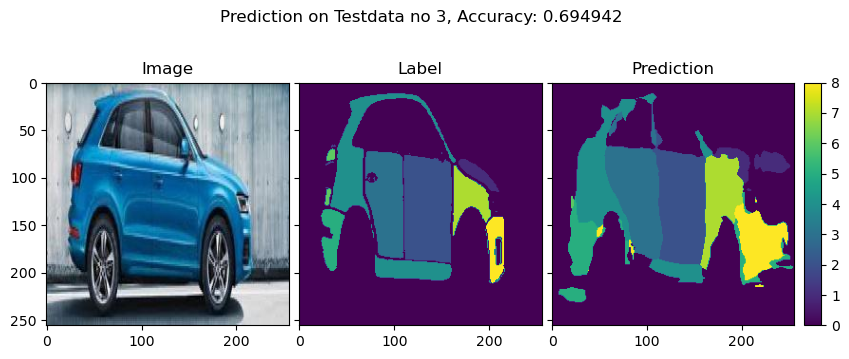

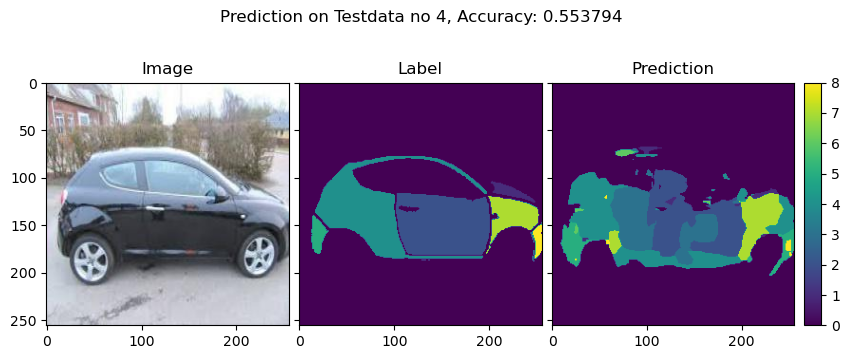

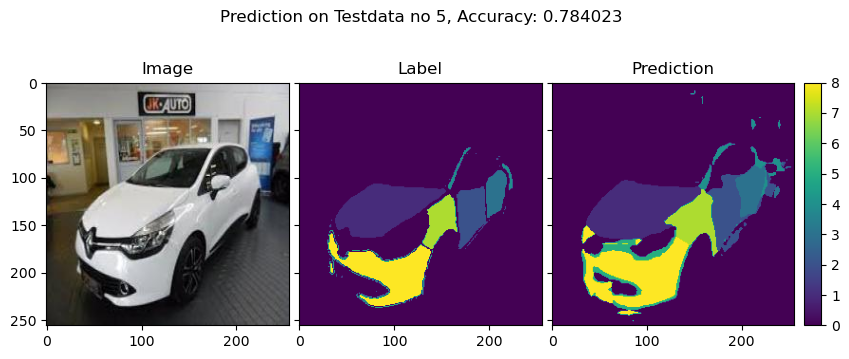

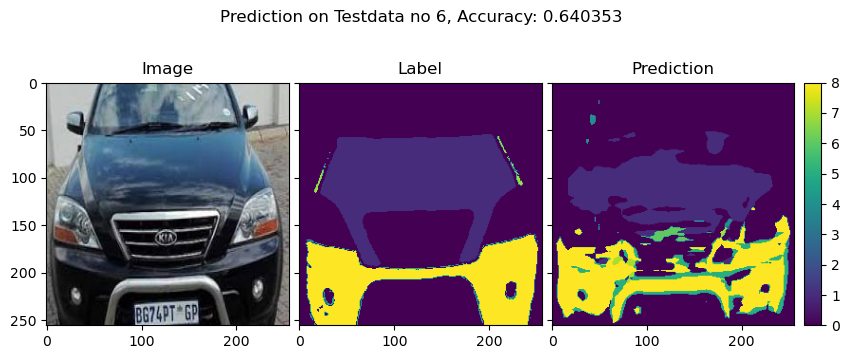

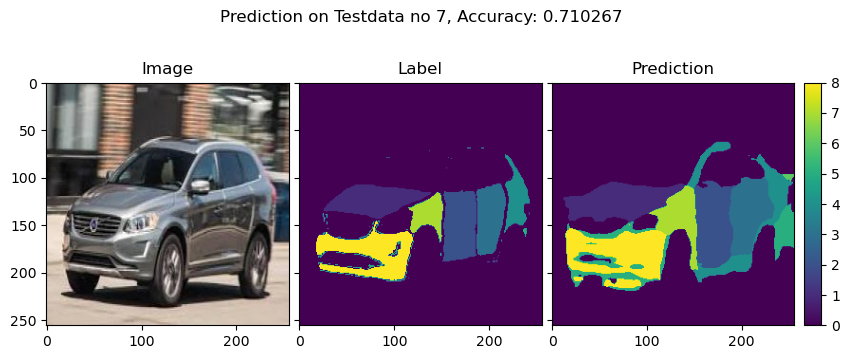

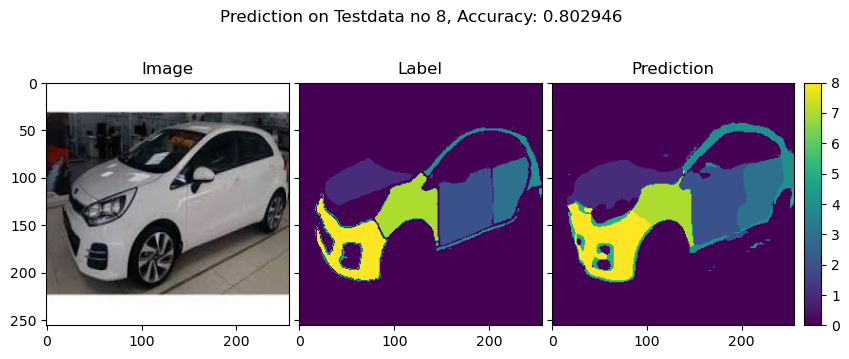

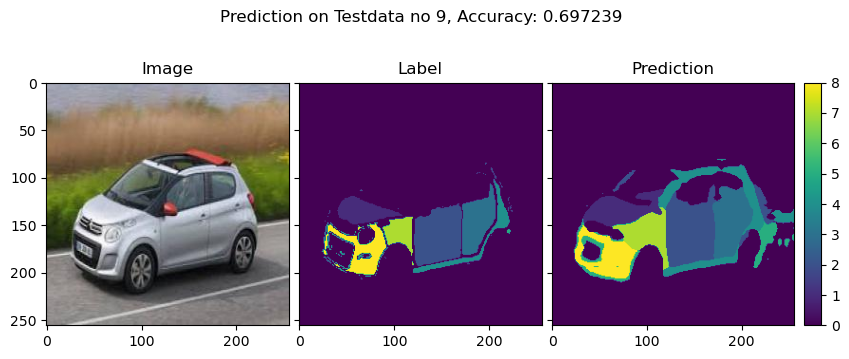

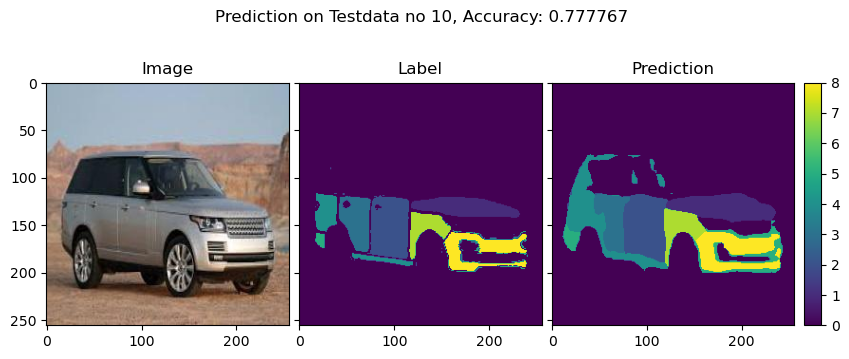

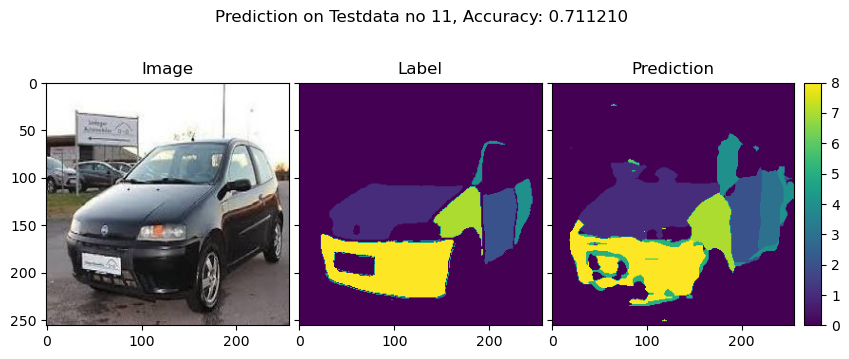

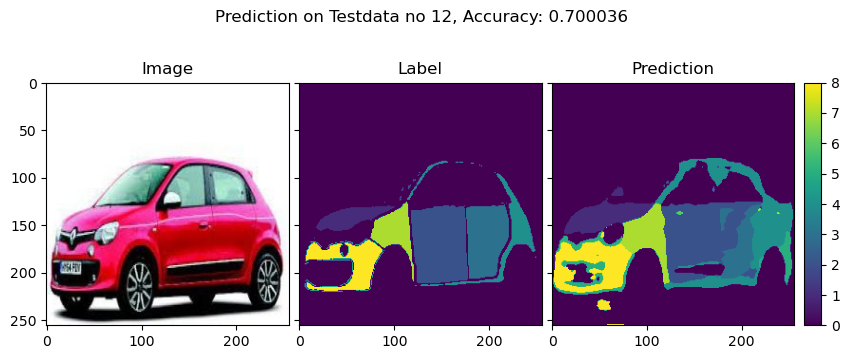

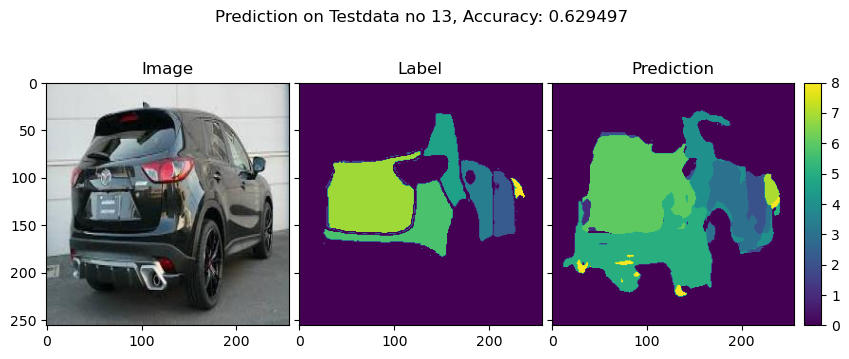

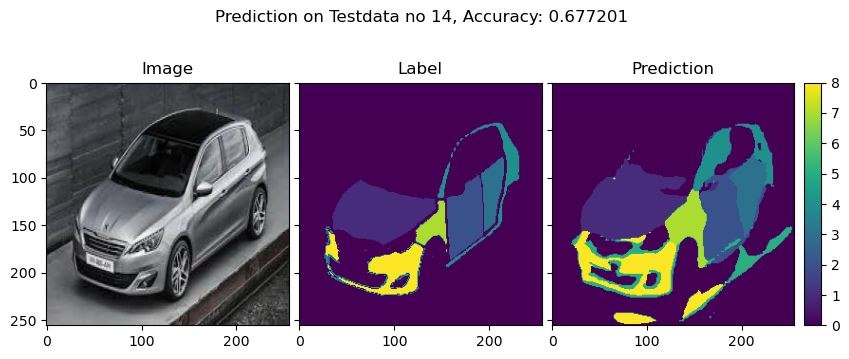

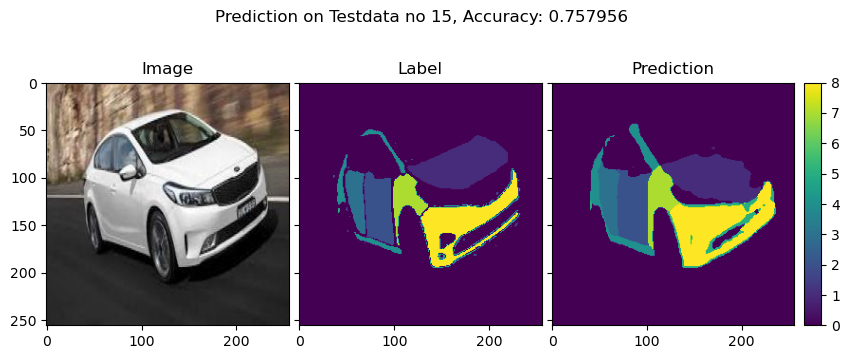

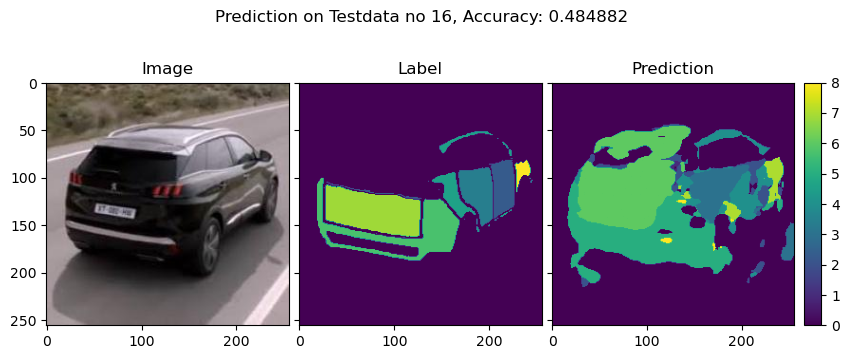

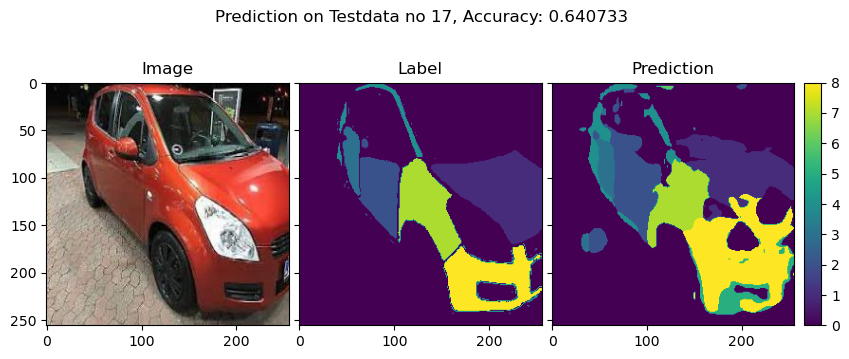

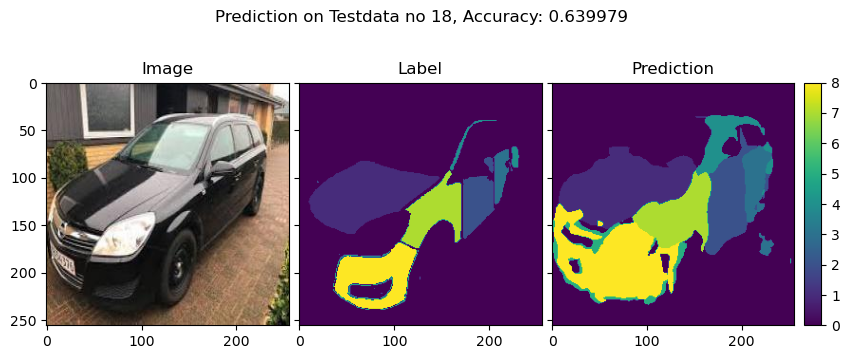

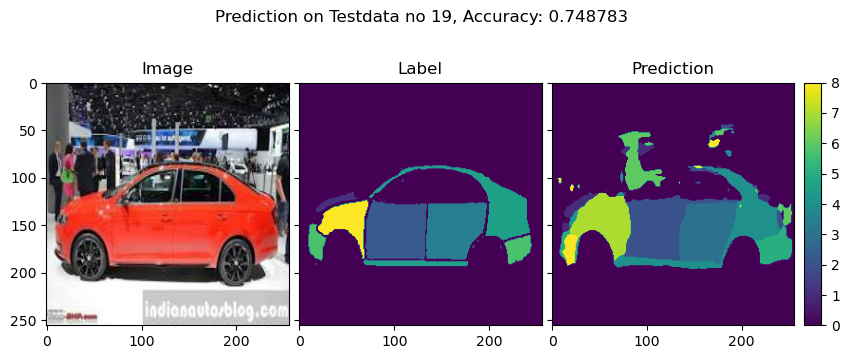

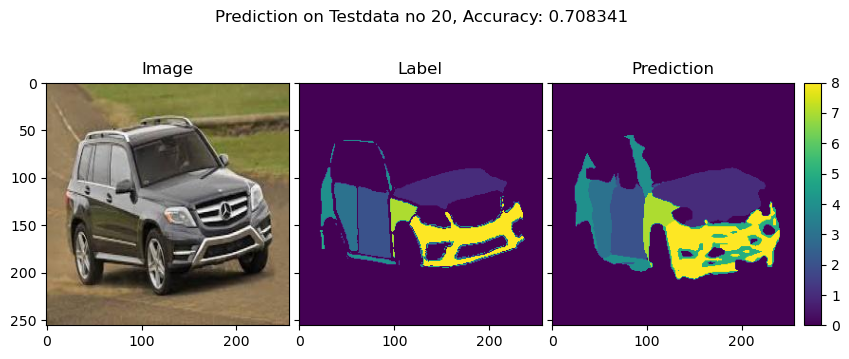

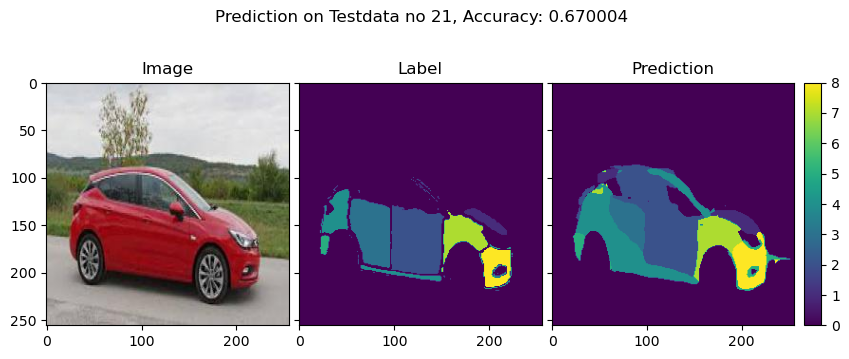

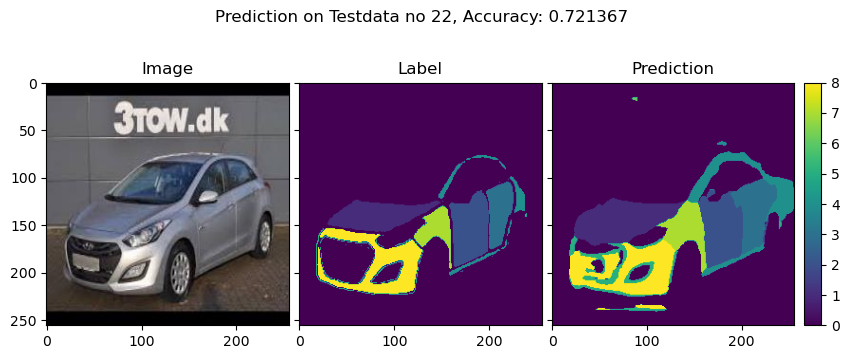

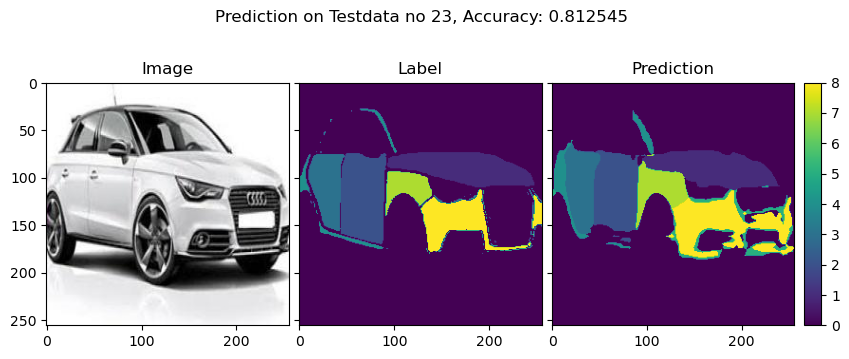

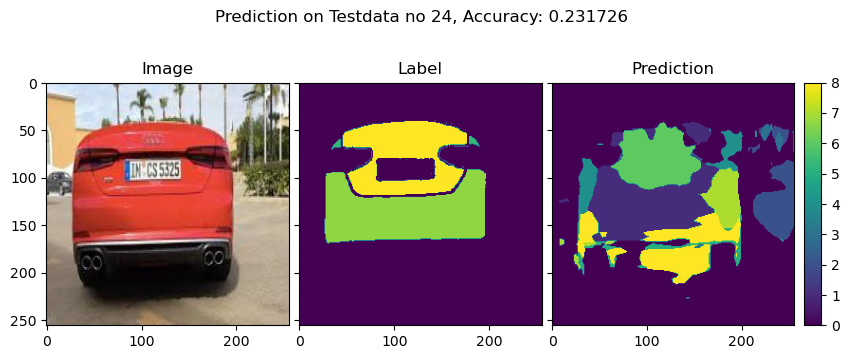

In [42]:

for i in range(len(test_dataset_deep)):
    image,target = test_dataset_deep[i]

    with torch.no_grad():
        lgt = net_deep(image.unsqueeze(0).to(device))
        preds = torch.max(lgt, 1)[1]

    im = image.cpu()
    im = im.permute(1,2,0)

    lb = target.cpu()
    
    acc = acc_score(lb,lgt)
    
    
    fig = plt.figure(figsize=(10,4))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,3),
                    axes_pad=0.1,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.1,
                    )


    plots = [im,lb,preds[0,:,:].cpu().detach()]
    ii = 0
    titles = ["Image", "Label", "Prediction"]
    for ax in grid:
        show = ax.imshow(plots[ii])
        ax.set_title(titles[ii])
        ii +=1
        
    ax.cax.colorbar(show)
    
    fig.suptitle("Prediction on Testdata no %d, Accuracy: %f"%(i,acc))

    plt.show()